# **Desafio Quant Itaú** 

### O objetivo desse notebook é criar uma estratégia quantitativa de investimento baseada em cryptomoedas.

### * *Essa é uma versão inicial.*

##### **1. Considerações Iniciais**

 - Pela importação dos dados ser mais simples, a lib `yfinance` será usada para criação de uma estratégia;
 - Posteriormente, a ideia é usar a API da Binance para fazer uma análise mais precisa e detalhada;
 - O período de otimização do modelo será de 2015 a 2021 (7 anos);
 - O peíodo de teste do modelo será de 2022 a 2023 (1 ano);
 - Para compor a carteira, consideraremos as vinte cryptomoedas com maior capitalização de mercado no dia 02/11/2024, segundo o CoinMarketCap.

    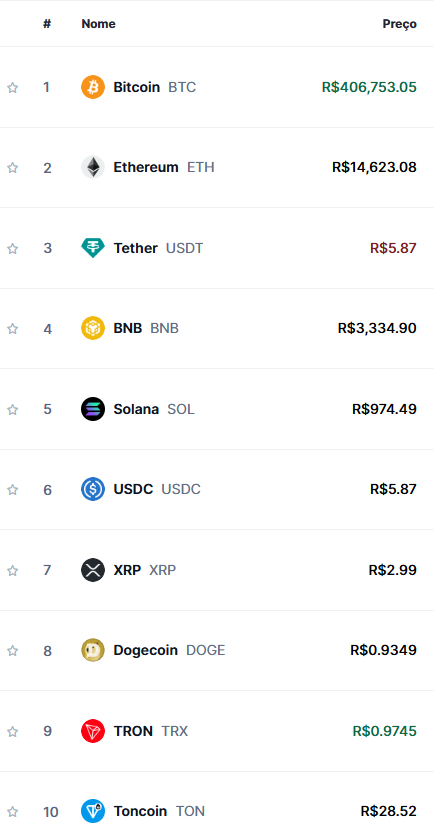 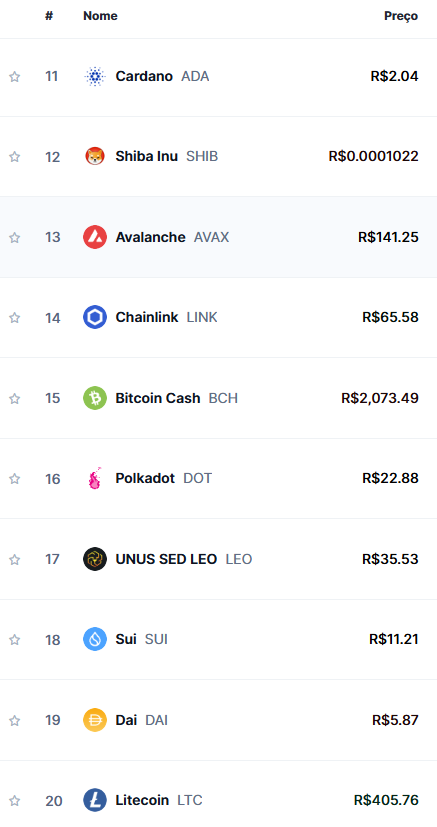

##### **2. Montando carteira**

- Por serem as duas cryptomoedas com maior capitalização de mercado, Bitcoin e Ethereum serão o “núcleo” da carteira.

- Cryptomoedas com correlação baixa serem selecionadas, para reduzir o risco da carteira.

- `Sui` e `DAI` tiveram que ser desconsideradas por terem sido lançadas em 2023 e 2017, respectivamente.

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

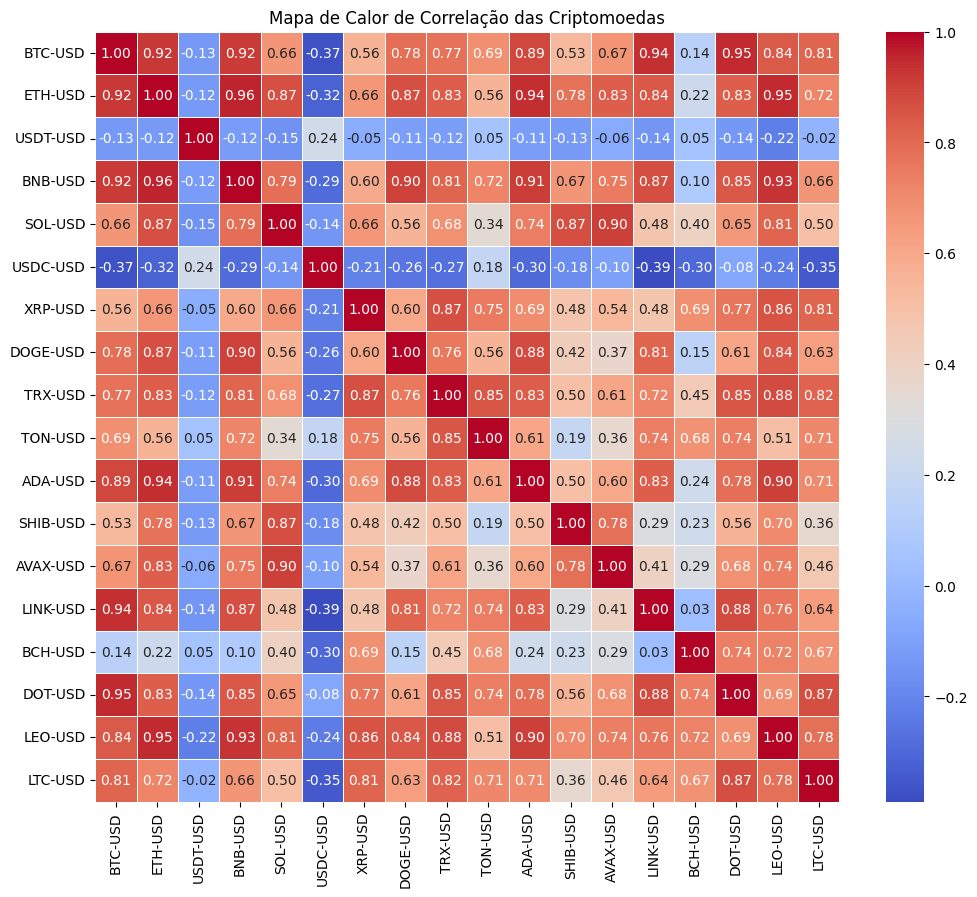

In [4]:
import yfinance as yf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Lista de tickers das 20 criptomoedas
tickers = [
    "BTC-USD", "ETH-USD", "USDT-USD", "BNB-USD", "SOL-USD", "USDC-USD", 
    "XRP-USD", "DOGE-USD", "TRX-USD", "TON-USD", "ADA-USD", "SHIB-USD", 
    "AVAX-USD", "LINK-USD", "BCH-USD", "DOT-USD", "LEO-USD", "LTC-USD"
]

# Inicializar um DataFrame vazio para armazenar os dados de fechamento ajustado
corr_crypto = pd.DataFrame()

# Baixar dados de fechamento ajustado para todas as criptomoedas e adicionar ao DataFrame
for ticker in tickers:
    dados = yf.download(ticker, start="2015-01-01", end="2022-01-01", interval="1d")["Adj Close"]
    corr_crypto[ticker] = dados

# Calcular a matriz de correlação
correlation_matrix = corr_crypto.corr()

# Plotar o mapa de calor da correlação
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Mapa de Calor de Correlação das Criptomoedas")
plt.show()
#plt.savefig("Correlacao_20_Cryptos.png", dpi=300)


- Selecionaremos ações com uma correlação menor do que $0.7$ com `Bitcoin` e `Ethereum` e menor do que $0.5$ entre elas:
    - USDT
    - USDC
    - BCH

- **Carteira - `Bitcoin (BTC-USD)`    `Ethereum (ETH-USD)`  `Tether (USDT-USD)`  `USD Coin (USDC-USD)`  `Bitcoin Cash (BCH-USD)`**

##### **3. Calculando os Pesos de cada Crypto**

- O peso de cada ativo na carteira será atribuído com base na volatilidade histórica, dando um peso menor para ativos mais voláteis e maior para os mais estáveis;

- Calcularemos a volatilidade total (desvio padrão dos retornos diários) de cada criptomoeda entre 2015 e 2021;

- Em seguida, invertemos a volatilidade para calcular os pesos;

- ***Explicação Detalhada***
    - **Download dos dados**: Baixamos os dados diários de fechamento ajustado de 2015 a 2022.
    - **Retornos diários**: Calculamos os retornos diários para medir a variação percentual diária dos preços.
    - **Volatilidade**: Multiplicamos o desvio padrão dos retornos diários por $\sqrt(7*252)$ (252 dias de negociação por ano) para encontrar a volatilidade.
    - **Calcular os pesos**: Invertemos a volatilidade para obter o fator proporcional dos pesos e normalizamos a soma para 1.

In [21]:
import yfinance as yf
import pandas as pd
import numpy as np

# Lista de criptomoedas e período de análise
carteira = ["BTC-USD", "ETH-USD", "USDT-USD", "USDC-USD", "BCH-USD"]
start_date = "2015-01-01"
end_date = "2021-12-31"

# Baixar dados de fechamento ajustado
dados_peso = yf.download(carteira, start=start_date, end=end_date, interval="1d")["Adj Close"]

# Calcular retornos diários
retornos_diarios = dados_peso.pct_change().dropna() # pct_change calcula a porcentagem de mudança de uma linha com a linha anterior

# Calcular a volatilidade anualizada (desvio padrão dos retornos diários anualizado)
volatilidade_anualizada = retornos_diarios.std() * np.sqrt(1764)

# Inverter a volatilidade para calcular os pesos (maior volatilidade = menor peso)
pesos_invertidos = 1 / volatilidade_anualizada
pesos = pesos_invertidos / pesos_invertidos.sum()

# Exibir os pesos calculados
print("Pesos da carteira com base na volatilidade histórica:")
for ticker, peso in zip(carteira, pesos):
    print(f"{ticker}: {peso:.2%}")

[*********************100%***********************]  5 of 5 completed

Pesos da carteira com base na volatilidade histórica:
BTC-USD: 2.97%
ETH-USD: 4.85%
USDT-USD: 3.76%
USDC-USD: 44.29%
BCH-USD: 44.14%


##### **4. Definição do Tipo de Estratégia**

- ***Estratégia de Média Móvel Simples:***
    - Consideração de duas médias móveis para cada ativo: uma de curto prazo (mais rápida) e uma de longo prazo (mais lenta);
    - A lógica é comprar um ativo quando a média móvel curta ultrapassa a média móvel longa (indicando uma tendência de alta) e vender quando ocorre o contrário (indicando uma tendência de baixa);
    - **Explicação Detalhada**:
        - *Estratégia de Média Móvel*: Definimos a função ``moving_average_strategy`` que calcula as médias móveis de curto e longo prazo e gera sinais de compra e venda.
        - *Otimização*: Testamos várias combinações de períodos para as médias móveis curtas (10 a 50 dias) e longas (100 a 250 dias) e escolhemos a combinação que maximiza o retorno cumulativo no   período de 2015 a 2021.
        - *Teste da Estratégia*: Usamos os parâmetros otimizados para cada criptomoeda e aplicamos a estratégia no período de 2022 a 2023.
        - *Resultados*: Calculamos e exibimos o retorno acumulado da estratégia de média móvel para cada criptomoeda durante o período de teste.
    

[*********************100%***********************]  5 of 5 completed
C:\Users\lucas\AppData\Local\Temp\ipykernel_10108\1240175419.py:21: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  signals['Signal'][short_window:] = np.where(signals['Short

Melhor janela para BTC-USD: Curta=10, Longa=100
Melhor janela para ETH-USD: Curta=20, Longa=100
Melhor janela para USDT-USD: Curta=10, Longa=250
Melhor janela para USDC-USD: Curta=10, Longa=250
Melhor janela para BCH-USD: Curta=10, Longa=100


C:\Users\lucas\AppData\Local\Temp\ipykernel_10108\1240175419.py:21: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  signals['Signal'][short_window:] = np.where(signals['Short_MA'][short_window:] > signals['Long_MA'][short_window:], 1.0, -1.0)


Retorno da estratégia para BTC-USD no período de teste: 12.68%
Retorno da estratégia para ETH-USD no período de teste: 33.89%
Retorno da estratégia para USDT-USD no período de teste: 0.15%
Retorno da estratégia para USDC-USD no período de teste: 0.15%
Retorno da estratégia para BCH-USD no período de teste: 19.01%

Retorno total da carteira no período de teste: 10.48%

Retornos da estratégia de média móvel no período de teste (2022 a 2023):
BTC-USD: 12.68%
ETH-USD: 33.89%
USDT-USD: 0.15%
USDC-USD: 0.15%
BCH-USD: 19.01%

Retorno total da carteira: 10.48%


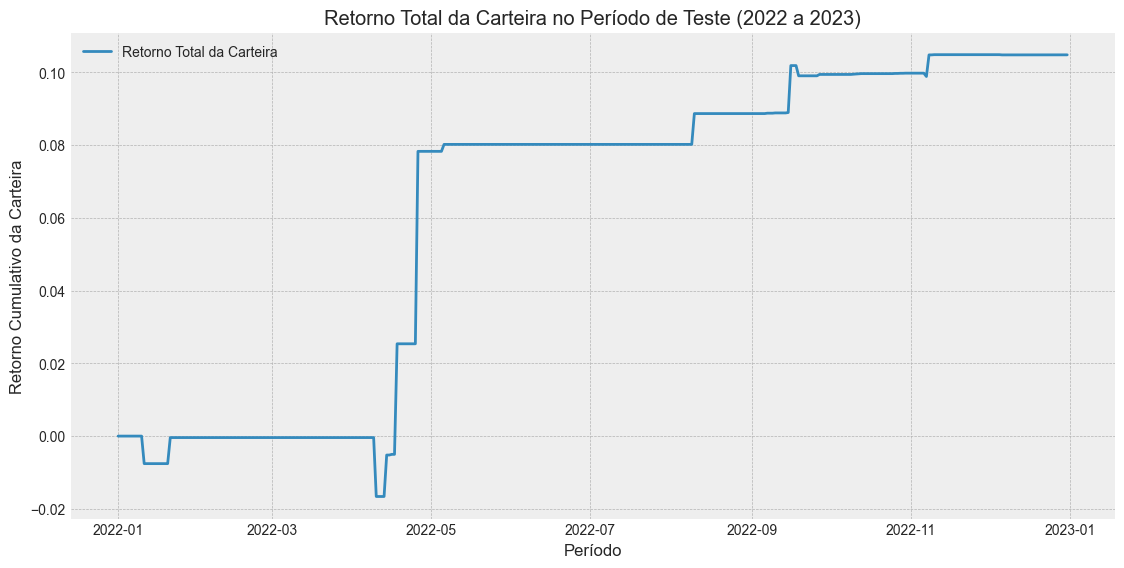

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np

# Configurações da estratégia
tickers = ["BTC-USD", "ETH-USD", "USDT-USD", "USDC-USD", "BCH-USD"]
start_date_train = "2015-01-01"
end_date_train = "2021-12-31"
start_date_test = "2022-01-01"
end_date_test = "2023-01-01"

# Função para executar a estratégia de média móvel
def moving_average_strategy(data, short_window=50, long_window=200):
    signals = pd.DataFrame(index=data.index)
    signals['Price'] = data
    signals['Short_MA'] = data.rolling(window=short_window).mean()
    signals['Long_MA'] = data.rolling(window=long_window).mean()
    signals['Signal'] = 0.0

    # Gerar sinais de compra (+1) e venda (-1)
    signals['Signal'][short_window:] = np.where(signals['Short_MA'][short_window:] > signals['Long_MA'][short_window:], 1.0, -1.0)
    signals['Position'] = signals['Signal'].diff()  # Identifica mudanças nos sinais

    return signals

# Baixar dados históricos de treinamento
dados_train = yf.download(tickers, start=start_date_train, end=end_date_train, interval="1d")["Adj Close"]

# Otimizar a estratégia para encontrar os melhores parâmetros de janela
best_params = {}
for ticker in tickers:
    data = dados_train[ticker].dropna()
    best_return = -np.inf
    best_short_window = None
    best_long_window = None
    
    # Testar várias combinações de janelas curtas e longas
    for short_window in range(10, 60, 10):  # Janela curta de 10 a 50 dias
        for long_window in range(100, 300, 50):  # Janela longa de 100 a 250 dias
            signals = moving_average_strategy(data, short_window, long_window)
            # Calcular o retorno cumulativo
            returns = (signals['Position'] * data.pct_change()).cumsum().iloc[-1]
            
            # Verificar se essa combinação é melhor
            if returns > best_return:
                best_return = returns
                best_short_window = short_window
                best_long_window = long_window
    
    # Salvar os melhores parâmetros para cada ativo
    best_params[ticker] = (best_short_window, best_long_window)
    print(f"Melhor janela para {ticker}: Curta={best_short_window}, Longa={best_long_window}")

# Testar a estratégia com os melhores parâmetros de 2022 a 2023
dados_test = yf.download(tickers, start=start_date_test, end=end_date_test, interval="1d")["Adj Close"]
strategy_results = {}
portfolio_returns = pd.DataFrame(index=dados_test.index)

# Pesos da carteira baseados na volatilidade histórica calculada anteriormente
pesos = {
    "BTC-USD": 0.0297,
    "ETH-USD": 0.0485,
    "USDT-USD": 0.0376,
    "USDC-USD": 0.4429,
    "BCH-USD": 0.4414
}

for ticker in tickers:
    data_test = dados_test[ticker].dropna()
    short_window, long_window = best_params[ticker]
    signals = moving_average_strategy(data_test, short_window, long_window)
    
    # Calcular o retorno da estratégia para cada criptomoeda
    signals['Strategy_Returns'] = signals['Position'] * data_test.pct_change()
    strategy_results[ticker] = signals['Strategy_Returns'].cumsum()
    portfolio_returns[ticker] = signals['Strategy_Returns']
    print(f"Retorno da estratégia para {ticker} no período de teste: {strategy_results[ticker].iloc[-1]:.2%}")

# Calcular o retorno da carteira ponderado pelos pesos
portfolio_returns['Total_Returns'] = portfolio_returns.mul(list(pesos.values()), axis=1).sum(axis=1).cumsum()
print(f"\nRetorno total da carteira no período de teste: {portfolio_returns['Total_Returns'].iloc[-1]:.2%}")

# Exibir os retornos finais da estratégia para cada criptomoeda e o retorno total da carteira
print("\nRetornos da estratégia de média móvel no período de teste (2022 a 2023):")
for ticker, returns in strategy_results.items():
    print(f"{ticker}: {returns.iloc[-1]:.2%}")

print(f"\nRetorno total da carteira: {portfolio_returns['Total_Returns'].iloc[-1]:.2%}")

# Gráfico do retorno total da carteira ao longo do tempo
import matplotlib.pyplot as plt
plt.style.use('bmh')
plt.figure(figsize=(12, 6))
plt.plot(portfolio_returns['Total_Returns'], label="Retorno Total da Carteira")
plt.title("Retorno Total da Carteira no Período de Teste (2022 a 2023)")
plt.xlabel("Período")
plt.ylabel("Retorno Cumulativo da Carteira")
plt.legend()
plt.show()

##### **5. Definindo o Benchmark**

- Vamos criar nosso próprio Benchmark (índice de referência);
- A ideia é montar uma carteira com `Bitcoin` `Ethereum` `Binance Coin` `Cardano` e `Solana`, com pesos iguais;

[*********************100%***********************]  5 of 5 completed

Retorno total do índice de criptomoedas no período: -76.23%


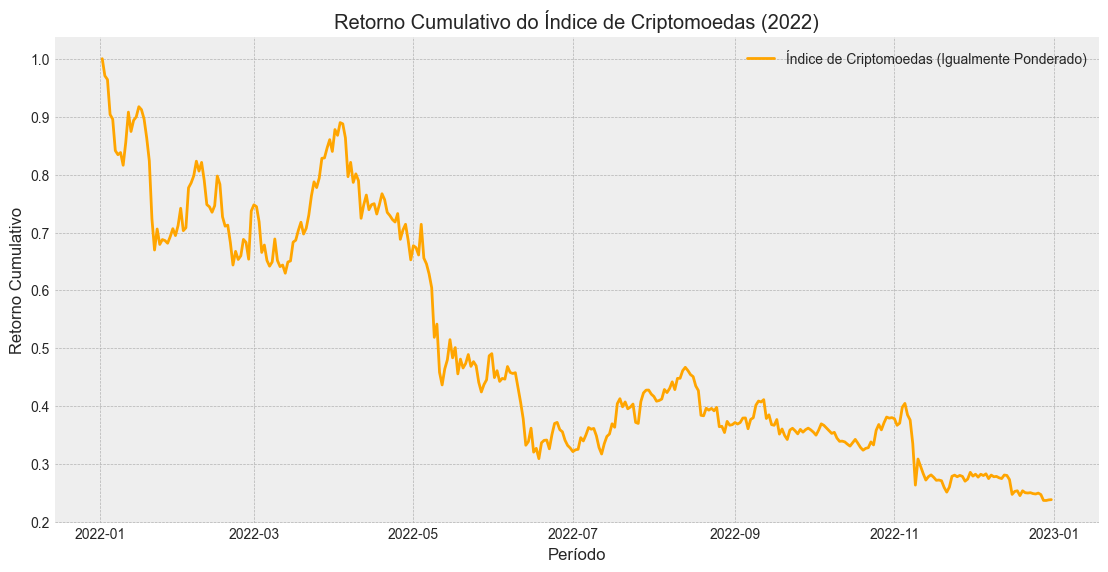

In [17]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Configurações do índice
crypto_symbols = ["BTC-USD", "ETH-USD", "BNB-USD", "ADA-USD", "SOL-USD"]
start_date_index = "2022-01-01"
end_date_index = "2023-01-01"

# Baixar dados históricos ajustados de fechamento para as criptomoedas no período de teste
crypto_data = yf.download(crypto_symbols, start=start_date_index, end=end_date_index)["Adj Close"]

# Calcular os retornos diários de cada criptomoeda e remover valores ausentes
crypto_returns = crypto_data.pct_change().dropna()

# Criar o índice igualmente ponderado (média dos retornos diários)
crypto_index_returns = crypto_returns.mean(axis=1)  # Retorno médio diário
crypto_index = (1 + crypto_index_returns).cumprod()  # Retorno cumulativo do índice

# Calcular o retorno total do índice
crypto_inicio = crypto_index.iloc[0]
crypto_fim = crypto_index.iloc[-1]
crypto_retorno_total = (crypto_fim / crypto_inicio) - 1
#crypto_retorno_anual = (1 + crypto_retorno_total) ** (1 / 1) - 1 - Vai ser o mesmo do retorno total (o período considerado é de um ano)

# Exibir o retorno anualizado do índice em 2022
print(f"Retorno total do índice de criptomoedas no período: {crypto_retorno_total * 100:.2f}%")

# Plotar o retorno do índice de criptomoedas para 2022
plt.style.use('bmh')
plt.figure(figsize=(12, 6))
plt.plot(crypto_index, label='Índice de Criptomoedas (Igualmente Ponderado)', color='orange')
plt.title("Retorno Cumulativo do Índice de Criptomoedas (2022)")
plt.xlabel("Período")
plt.ylabel("Retorno Cumulativo")
plt.legend()
plt.show()

##### **6. Comparando com a Carteria**

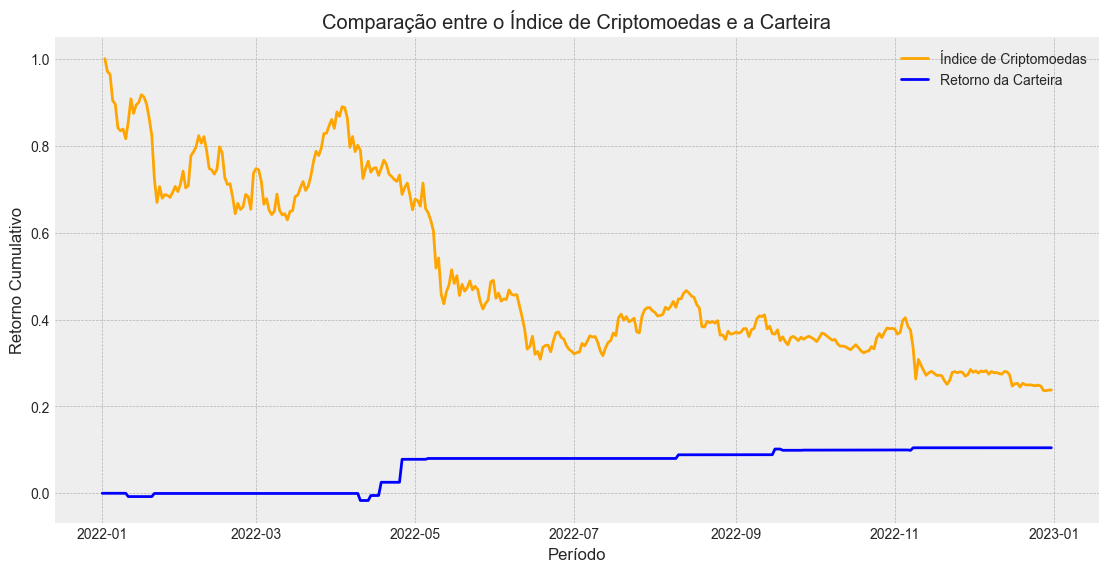

In [16]:
# Plotar os retornos
plt.style.use('bmh')
plt.figure(figsize=(12, 6))
plt.plot(crypto_index, label='Índice de Criptomoedas', color='orange')
plt.plot(portfolio_returns['Total_Returns'], label='Retorno da Carteira', color='blue')
plt.title('Comparação entre o Índice de Criptomoedas e a Carteira')
plt.xlabel('Período')
plt.ylabel('Retorno Cumulativo')
plt.legend()
plt.show()

##### **7. Aumentando o Período de Teste**

- Período: 01/01/2022 a 30/09/2024

[*********************100%***********************]  5 of 5 completed
C:\Users\lucas\AppData\Local\Temp\ipykernel_10108\4258087793.py:22: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  signals['Signal'][short_window:] = np.where(signals['Short

Melhor janela para BTC-USD: Curta=10, Longa=100
Melhor janela para ETH-USD: Curta=20, Longa=100
Melhor janela para USDT-USD: Curta=10, Longa=250
Melhor janela para USDC-USD: Curta=10, Longa=250
Melhor janela para BCH-USD: Curta=10, Longa=100


C:\Users\lucas\AppData\Local\Temp\ipykernel_10108\4258087793.py:22: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  signals['Signal'][short_window:] = np.where(signals['Short_MA'][short_window:] > signals['Long_MA'][short_window:], 1.0, -1.0)



Retornos da estratégia de média móvel no período de teste (2022 a 2024):
BTC-USD: 35.35%
ETH-USD: 25.56%
USDT-USD: 0.53%
USDC-USD: 0.32%
BCH-USD: 89.08%

Retorno total da carteira: 41.77%
Retorno total do índice de criptomoedas no período: -30.27%


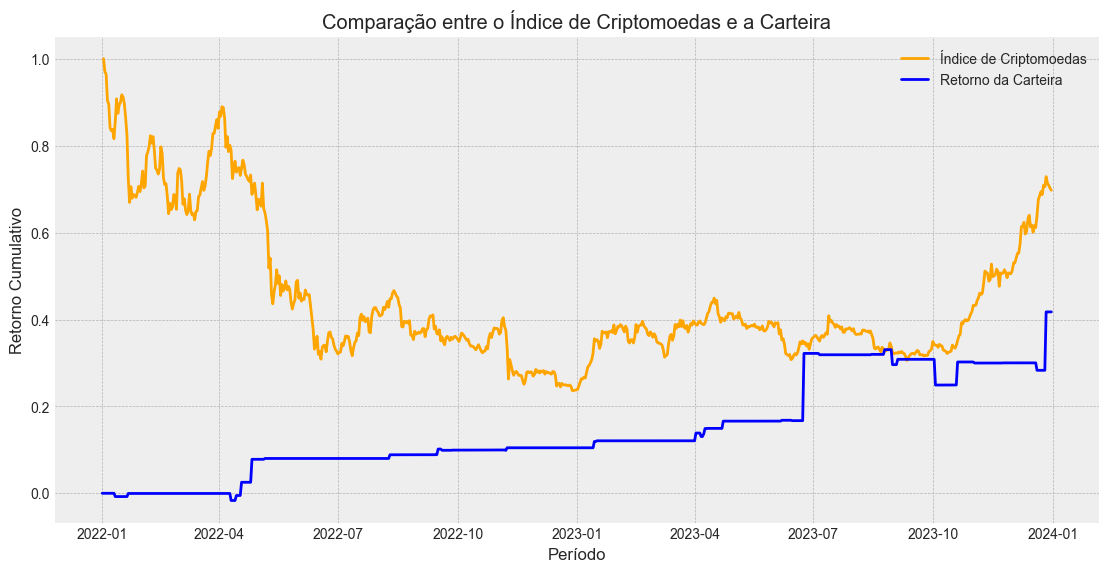

In [19]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Configurações da estratégia
tickers = ["BTC-USD", "ETH-USD", "USDT-USD", "USDC-USD", "BCH-USD"]
start_date_train = "2015-01-01"
end_date_train = "2021-12-31"
start_date_test = "2022-01-01"
end_date_test = "2024-01-01"

# Função para executar a estratégia de média móvel
def moving_average_strategy(data, short_window=50, long_window=200):
    signals = pd.DataFrame(index=data.index)
    signals['Price'] = data
    signals['Short_MA'] = data.rolling(window=short_window).mean()
    signals['Long_MA'] = data.rolling(window=long_window).mean()
    signals['Signal'] = 0.0

    # Gerar sinais de compra (+1) e venda (-1)
    signals['Signal'][short_window:] = np.where(signals['Short_MA'][short_window:] > signals['Long_MA'][short_window:], 1.0, -1.0)
    signals['Position'] = signals['Signal'].diff()  # Identifica mudanças nos sinais

    return signals

# Baixar dados históricos de treinamento
dados_train = yf.download(tickers, start=start_date_train, end=end_date_train, interval="1d")["Adj Close"]

# Otimizar a estratégia para encontrar os melhores parâmetros de janela
best_params = {}
for ticker in tickers:
    data = dados_train[ticker].dropna()
    best_return = -np.inf
    best_short_window = None
    best_long_window = None
    
    # Testar várias combinações de janelas curtas e longas
    for short_window in range(10, 60, 10):  # Janela curta de 10 a 50 dias
        for long_window in range(100, 300, 50):  # Janela longa de 100 a 250 dias
            signals = moving_average_strategy(data, short_window, long_window)
            # Calcular o retorno cumulativo
            returns = (signals['Position'] * data.pct_change()).cumsum().iloc[-1]
            
            # Verificar se essa combinação é melhor
            if returns > best_return:
                best_return = returns
                best_short_window = short_window
                best_long_window = long_window
    
    # Salvar os melhores parâmetros para cada ativo
    best_params[ticker] = (best_short_window, best_long_window)
    print(f"Melhor janela para {ticker}: Curta={best_short_window}, Longa={best_long_window}")

# Testar a estratégia com os melhores parâmetros de 2022 a 2023
dados_test = yf.download(tickers, start=start_date_test, end=end_date_test, interval="1d")["Adj Close"]
strategy_results = {}
portfolio_returns = pd.DataFrame(index=dados_test.index)

# Pesos da carteira baseados na volatilidade histórica calculada anteriormente
pesos = {
    "BTC-USD": 0.0297,
    "ETH-USD": 0.0485,
    "USDT-USD": 0.0376,
    "USDC-USD": 0.4429,
    "BCH-USD": 0.4414
}

for ticker in tickers:
    data_test = dados_test[ticker].dropna()
    short_window, long_window = best_params[ticker]
    signals = moving_average_strategy(data_test, short_window, long_window)
    
    # Calcular o retorno da estratégia para cada criptomoeda
    signals['Strategy_Returns'] = signals['Position'] * data_test.pct_change()
    strategy_results[ticker] = signals['Strategy_Returns'].cumsum()
    portfolio_returns[ticker] = signals['Strategy_Returns']
    #print(f"Retorno da estratégia para {ticker} no período de teste: {strategy_results[ticker].iloc[-1]:.2%}")

# Calcular o retorno da carteira ponderado pelos pesos
portfolio_returns['Total_Returns'] = portfolio_returns.mul(list(pesos.values()), axis=1).sum(axis=1).cumsum()
#print(f"\nRetorno total da carteira no período de teste: {portfolio_returns['Total_Returns'].iloc[-1]:.2%}")

# Exibir os retornos finais da estratégia para cada criptomoeda e o retorno total da carteira
print("\nRetornos da estratégia de média móvel no período de teste (2022 a 2024):")
for ticker, returns in strategy_results.items():
    print(f"{ticker}: {returns.iloc[-1]:.2%}")

print(f"\nRetorno total da carteira: {portfolio_returns['Total_Returns'].iloc[-1]:.2%}")

# Configurações do índice
crypto_symbols = ["BTC-USD", "ETH-USD", "BNB-USD", "ADA-USD", "SOL-USD"]
start_date_index = "2022-01-01"
end_date_index = "2024-01-01"

# Baixar dados históricos ajustados de fechamento para as criptomoedas no período de teste
crypto_data = yf.download(crypto_symbols, start=start_date_index, end=end_date_index)["Adj Close"]

# Calcular os retornos diários de cada criptomoeda e remover valores ausentes
crypto_returns = crypto_data.pct_change().dropna()

# Criar o índice igualmente ponderado (média dos retornos diários)
crypto_index_returns = crypto_returns.mean(axis=1)  # Retorno médio diário
crypto_index = (1 + crypto_index_returns).cumprod()  # Retorno cumulativo do índice

# Calcular o retorno total do índice
crypto_inicio = crypto_index.iloc[0]
crypto_fim = crypto_index.iloc[-1]
crypto_retorno_total = (crypto_fim / crypto_inicio) - 1
# crypto_retorno_anual = (1 + crypto_retorno_total) ** (1 / 2) - 1 - Retorno anualizado

# Exibir o retorno anualizado do índice em 2022
print(f"Retorno total do índice de criptomoedas no período: {crypto_retorno_total * 100:.2f}%")

# Plotar os retornos
plt.style.use('bmh')
plt.figure(figsize=(12, 6))
plt.plot(crypto_index, label='Índice de Criptomoedas', color='orange')
plt.plot(portfolio_returns['Total_Returns'], label='Retorno da Carteira', color='blue')
plt.title('Comparação entre o Índice de Criptomoedas e a Carteira')
plt.xlabel('Período')
plt.ylabel('Retorno Cumulativo')
plt.legend()
plt.show()